In [ ]:
!git checkout .

In [ ]:
#@title Mount google drive and git pull
# this cell is to load the google drive to the directory
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My\ Drive/Hpython/nem_ss
!git checkout multi_real
!git pull

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/Hpython/nem_ss
Already on 'multi_real'
Your branch is behind 'origin/multi_real' by 1 commit, and can be fast-forwarded.
  (use "git pull" to update your local branch)
Updating c60ceb2..bf614b0
Fast-forward
 unet/unet_model.py | 2 +-
 utils.py           | 1 +
 2 files changed, 2 insertions(+), 1 deletion(-)


In [ ]:
#@title Loading packages
!pip install torch_optimizer
import os
import h5py 
import numpy as np
import scipy.io as sio
from scipy.signal import stft 
import itertools

import torch
from torch import nn
import torch.nn.functional as Func
import torch.utils.data as Data
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter
plt.rcParams['figure.dpi'] = 100

# from unet.unet_model import UNet

"make the result reproducible"
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [ ]:
#@title Load data

# %% toy experiment 3
"""only generate 1-class vj and let it move. Also train only one neural network to see if it could capture
the patter
"""
from utils import *
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

#%% load options for training 
opts = {}
opts['n_epochs'] = 200  
opts['lr'] = 0.01
opts['n_batch'] = 64  # batch size
opts['d_gamma'] = 16 # gamma dimesion 16*16 to 200*200

# %% load data
from PIL import Image  # install Pillow
d = Image.open('../data/vj150.png')
d = np.array(d)
d = torch.tensor(1-d[...,0]/255).float()

# row 44 has 1, column 47 has 1
F, T = d.shape
N = 10000
data = torch.zeros(N, F, T)
n = 0
for r in range(105):
    for c in range(102):
        if n < N:
            data[n] = torch.roll(d, (r, c), (0, 1))
            n += 1
gamma = torch.rand(N, opts['d_gamma'], opts['d_gamma'])
" wrap as data loader"
ind = torch.randperm(N)
gamma, data = gamma[ind], data[ind]
data = Data.TensorDataset(gamma[:3000], data[:3000])
tr = Data.DataLoader(data, batch_size=opts['n_batch'], shuffle=False, drop_last=True)


In [ ]:
#%% set neural networks
from unet.unet_model import UNetHalf
model, e = torch.load('model_epoch_99.pt')
for param in model.parameters():
    param.requires_grad_(False)
gamma, v = next(iter(tr))
v = v[:,None].cuda()
loss_cv = []

x = gamma[:,None].cuda().requires_grad_()
optim_gamma = torch.optim.SGD([x], lr= opts['lr'])  # every iter the gamma grad is reset

for epoch in range(opts['n_epochs']):    
    "update gamma"
    out = model(x)
    loss = ((out - v)**2).sum()/opts['n_batch']
    optim_gamma.zero_grad()   
    loss.backward()
    torch.nn.utils.clip_grad_norm_([x], max_norm=500)
    optim_gamma.step()
    torch.cuda.empty_cache()

    "update model"
    # for param in model.parameters():
    #     param.requires_grad_(True)
    # x = gamma[:,None].cuda()
    # out = model(x)
    # loss = ((out - v)**2).sum()/opts['n_batch']
    # optimizer.zero_grad()   
    # loss.backward()
    # torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=500)
    # optimizer.step()
    # torch.cuda.empty_cache()

    loss_cv.append(loss.detach().item())

    if epoch%1 ==0:
        plt.figure()
        plt.semilogy(loss_cv, '--xr')
        plt.title('val loss per epoch')
        plt.show()

        plt.figure()
        plt.imshow(out[0,0].detach().cpu())
        plt.show()

        plt.figure()
        plt.imshow(v[0,0].detach().cpu())
        plt.title('Ground Truth')
        plt.show()


Output hidden; open in https://colab.research.google.com to view.

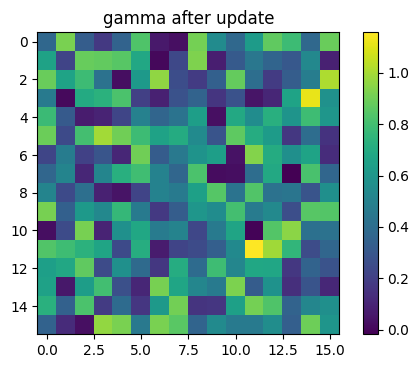

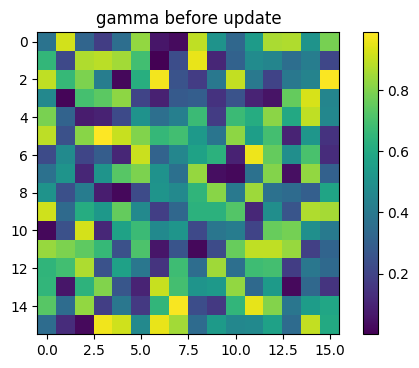

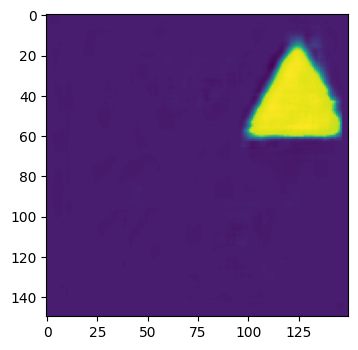

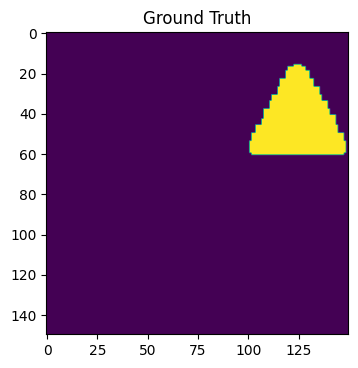

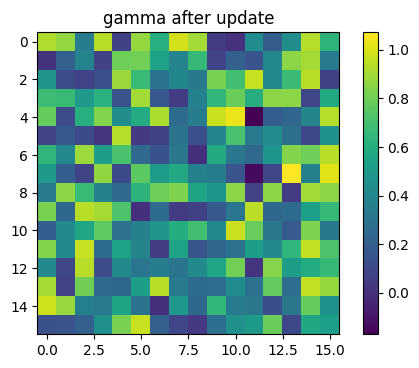

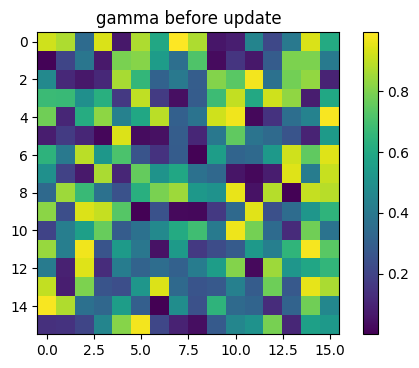

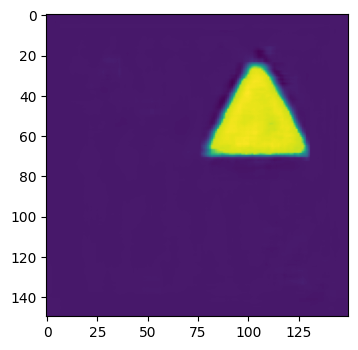

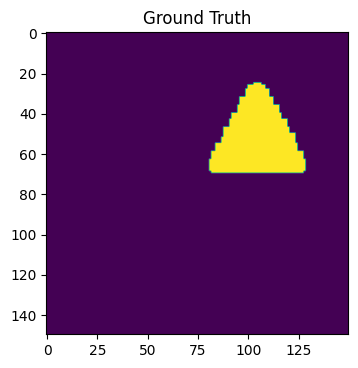

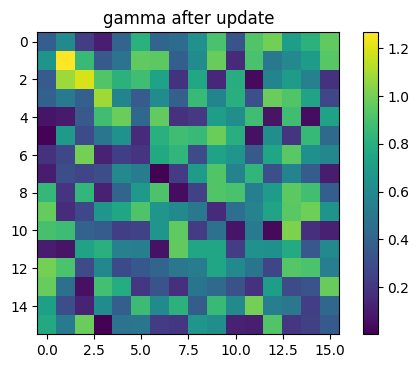

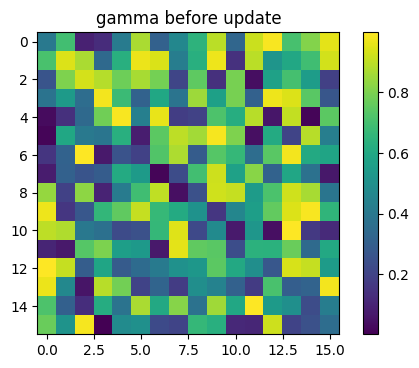

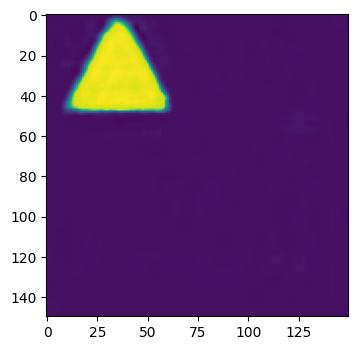

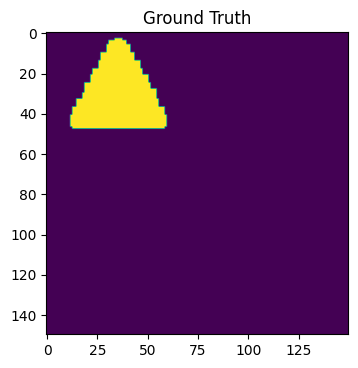

In [ ]:
for i in [1, 30, 50]:
    plt.figure()
    plt.imshow(x[i,0].detach().cpu())
    plt.colorbar()
    plt.title('gamma after update')
    plt.show()

    plt.figure()
    plt.imshow(gamma[i].detach().cpu())
    plt.colorbar()
    plt.title('gamma before update')
    plt.show()

    plt.figure()
    plt.imshow(out[i,0].detach().cpu())
    plt.show()

    plt.figure()
    plt.imshow(v[i,0].detach().cpu())
    plt.title('Ground Truth')
    plt.show()